<a href="https://colab.research.google.com/github/shanikagalaudage/tutorials_resources/blob/main/population_models_and_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Getting started**
Let's install some stuff first for plotting and parameter estimation

In [1]:
!pip install gwpopulation

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.2 MB 6.8 MB/s 
     |████████████████████████████████| 86 kB 6.5 MB/s 
     |████████████████████████████████| 46 kB 4.9 MB/s 
  Created wheel for gwpopulation: filename=gwpopulation-0.6.3-py3-none-any.whl size=20680 sha256=7a8fcf75170910fd7606a3e14bf75d26f26ff02037f2d90aed171ccd7d9f5d66
  Stored in directory: /root/.cache/pip/wheels/ff/92/9b/ca6c3148c2355ab7b6de2468d6ab3090ba1dc71d52eaa46294
  Created wheel for bilby: filename=bilby-1.1.5-py3-none-any.whl size=2250290 sha256=ac4843790e707a129ac5a971af9b2530785cc1a6e27e623eb5fde9d126222219
  Stored in directory: /root/.cache/pip/wheels/d9/4b/7f/9b616adfbe3e613bf0abe6c320a9b5bc988e411201c12eca19
Successfully built gwpopulation bilby


In [2]:
! pip install deepdish

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# import stuff
from importlib import import_module
import inspect
import numpy as np
import pandas as pd
import deepdish as dd
from scipy import special
from bilby import run_sampler
import gwpopulation
import bilby
from bilby.core.prior import PriorDict, Uniform, LogUniform, PowerLaw, Interped
from bilby.hyper.model import Model
import matplotlib.pyplot as plt
from matplotlib import rcParams

# formatting for figures
rcParams["text.usetex"] = False
rcParams["font.serif"] = "Computer Modern"
rcParams["font.family"] = "DejaVu Sans"

rcParams["legend.fontsize"]=14
rcParams["legend.framealpha"]=0.5
rcParams["legend.frameon"]=True
rcParams["legend.edgecolor"]="white"
rcParams["axes.labelsize"]=14
rcParams["axes.grid"] = True
rcParams["grid.color"] = "black"
rcParams["grid.linewidth"] = 1
rcParams["grid.linestyle"] = "--"
rcParams["grid.alpha"] = 0.3

rcParams["xtick.labelsize"]=16
rcParams["ytick.labelsize"]=16
rcParams["legend.fontsize"]=16
rcParams["axes.labelsize"]=18
rcParams["axes.titlesize"]=18

## **Let's talk about populations**

First things first, let's define our population model.

In [4]:
# define a hyper prior (i.e priors for our hyper parameters)

hyper_prior = PriorDict()
hyper_prior['mu'] = Uniform(minimum=20, maximum=50, name='mu1', latex_label='$\\mu_{1}$')
hyper_prior['sig'] = Uniform(minimum=1, maximum=10, name='sig1', latex_label='$\\sigma_{1}$')
hyper_prior['mmin'] = 3
hyper_prior['mmax'] = 100
hyper_prior['lamb'] = 0

In [5]:
# define a population model

def truncated_gaussian(xx, mu, sigma, high, low):
    norm = 2 ** 0.5 / np.pi ** 0.5 / sigma
    norm /= special.erf((high - mu) / 2 ** 0.5 / sigma) + special.erf((mu - low) / 2 ** 0.5 / sigma)
    prob = np.exp(-np.power(xx - mu, 2) / (2 * sigma ** 2))
    prob *= norm
    prob *= (xx <= high) & (xx >= low)
    return prob

def single_gaussian(dataset, mmin, mmax, mu, sig):
    prob = truncated_gaussian(dataset["mass_1"], mu=mu, sigma=sig, low=mmin, high=mmax)
    return prob

In [6]:
# read in GWTC-1 posteriors
posteriors = pd.read_pickle("./posteriors_gwtc1.pkl")

So the following functions look a little bit intense, but you can ignore them for the time being (if you have questions, please ask!). Essentially all they are doing is calculating the selection effects which gives a $1/p_\mathrm{det}$ factor to the likelihood where $p_\mathrm{det}$ is the probability of detection.

In [7]:
# Set selection function

N_EVENTS = len(posteriors)
max_redshift = 2.3

class ResamplingVT(object):
    def __init__(self, model, data):
        self.data = data
        if isinstance(model, list):
            model = Model(model)
        elif not isinstance(model, Model):
            model = Model([model])
        self.model = model
        self.redshift_model = None
        for _model in self.model.models:
            if isinstance(_model, gwpopulation.models.redshift._Redshift):
                self.redshift_model = _model
        if self.redshift_model is None:
            self._surveyed_hypervolume = total_four_volume(
                lamb=0, analysis_time=self.data["analysis_time"]
            )

    def __call__(self, parameters):
        mu, var = self.detection_efficiency(parameters)
        n_effective = mu ** 2 / var
        if n_effective < 4 * N_EVENTS:
            return np.inf
        vt_factor = mu / np.exp((3 + N_EVENTS) / 2 / n_effective)
        return vt_factor

    def detection_efficiency(self, parameters):
        self.model.parameters.update(parameters)
        weights = self.model.prob(self.data) / self.data["prior"]
        mu = float(np.sum(weights) / self.data["total_generated"])
        var = float(
            np.sum(weights ** 2) / self.data["total_generated"] ** 2
            - mu ** 2 / self.data["total_generated"]
        )
        return mu, var

    def surveyed_hypervolume(self, parameters):
        if self.redshift_model is None:
            return self._surveyed_hypervolume
        else:
            return (
                self.redshift_model.total_spacetime_volume(**parameters)
                / 1e9
                * self.data["analysis_time"]
            )


def _load_pycbc_injection_data(vt_file, ifar_threshold=1, vt_name="N_exp/R(z=0)"):
    data = dd.io.load(vt_file)
    found = (
        (data["injections"]["ifar_pycbc_bbh"] > ifar_threshold)
        | (data["injections"]["ifar_pycbc_full"] > ifar_threshold)
        | (data["injections"]["ifar_gstlal"] > ifar_threshold)
    )
    gwpop_data = dict(
        mass_1=np.asarray(data["injections"]["mass1_source"][found]),
        mass_ratio=np.asarray(
            data["injections"]["mass2_source"][found]
            / data["injections"]["mass1_source"][found]
        ),
        redshift=np.asarray(data["injections"]["redshift"][found]),
        prior=np.asarray(data["injections"]["sampling_pdf"][found]),
        n_found=sum(found),
        total_generated=data["total_generated"],
        analysis_time=data["analysis_time_s"] / 365.25 / 24 / 60 / 60,
    )
    return gwpop_data


def injection_resampling_vt(vt_file, model, ifar_threshold=1):
    data = _load_pycbc_injection_data(vt_file=vt_file, ifar_threshold=ifar_threshold)
    return ResamplingVT(model=model, data=data)


def injection_resampling_vt_no_redshift(vt_file, model, ifar_threshold=1):
    data = _load_pycbc_injection_data(vt_file=vt_file, ifar_threshold=ifar_threshold)
    data["prior"] = data["mass_1"] ** (-2.35 + 1) * data["mass_ratio"] ** 2
    return ResamplingVT(model=model, data=data)


def total_four_volume(lamb, analysis_time, max_redshift=2.3):
    redshifts = np.linspace(0, max_redshift, 1000)
    psi_of_z = (1 + redshifts) ** lamb
    total_volume = (
        np.trapz(
            Planck15.differential_comoving_volume(redshifts).value
            / (1 + redshifts)
            * psi_of_z,
            redshifts,
        ) * 4 * np.pi / 1e9 * analysis_time
    )
    return total_volume

def _load_model(model):
    if "." in model:
        split_model = model.split(".")
        module = ".".join(split_model[:-1])
        function = split_model[-1]
        _model = getattr(import_module(module), function)

    else:
        _model = MODEL_MAP[model]
    if inspect.isclass(_model):
        if "redshift" in model.lower():
            kwargs = dict(z_max=2.3)
        else:
            kwargs = dict()
        _model = _model(**kwargs)
    return _model


In [8]:
# sets models for mass (your model) and redshift (a model available in GWPopulation)

MODEL_MAP = {
    "single_gaussian": single_gaussian,
}

vt_models = ["single_gaussian", "gwpopulation.models.redshift.PowerLawRedshift"]
vt_file = "o1_o2_o3a_vt_data_aligned_low_spin.hdf5"
vt_model = Model([_load_model(model) for model in vt_models])
selection = injection_resampling_vt(vt_file=vt_file, model=vt_model)

models = Model([_load_model(model) for model in vt_models])

In [9]:
# set up likelihood function

likelihood = gwpopulation.hyperpe.HyperparameterLikelihood(
        posteriors,
        models,
        conversion_function=gwpopulation.conversions.convert_to_beta_parameters,
        selection_function=selection,
    )

likelihood.parameters.update(hyper_prior.sample())
likelihood.log_likelihood_ratio()

04:23 bilby WARNING : Cannot import cupy, falling back to numpy.


-276.99106422765396

In [10]:
# run sampler (fast settings)

result = run_sampler(
    likelihood=likelihood,
    priors=hyper_prior,
    label="test",
    sampler="dynesty",
    outdir=".",
    nlive=100, walks=5
    )

04:23 bilby INFO    : Running for label 'test', output will be saved to '.'
04:23 bilby INFO    : Search parameters:
04:23 bilby INFO    :   mu = Uniform(minimum=20, maximum=50, name='mu1', latex_label='$\\mu_{1}$', unit=None, boundary=None)
04:23 bilby INFO    :   sig = Uniform(minimum=1, maximum=10, name='sig1', latex_label='$\\sigma_{1}$', unit=None, boundary=None)
04:23 bilby INFO    :   mmin = 3
04:23 bilby INFO    :   mmax = 100
04:23 bilby INFO    :   lamb = 0
04:23 bilby INFO    : Single likelihood evaluation took 2.804e-03 s


0it [00:00, ?it/s]

04:23 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 1800, 'nlive': 100, 'first_update': None, 'walks': 5, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 60, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7efcf91db2d0>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5, 'print_method': 'tqdm'}
04:23 bilby INFO    : Checkpoint every check_point_delta_t = 600s
04:23 bilby INFO    : Using dynesty version 1.0.1
04:23 bilby INFO    : Using the bilby-

/usr/local/lib/python3.7/dist-packages/yaml/constructor.py:126: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(key, collections.Hashable):
/usr/local/lib/python3.7/dist-packages/dask/array/numpy_compat.py:21: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.divide(0.4, 1, casting="unsafe", dtype=np.float),
/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 88 from PyObject
  return f(*args, **kwds)
/usr/local/lib/python3

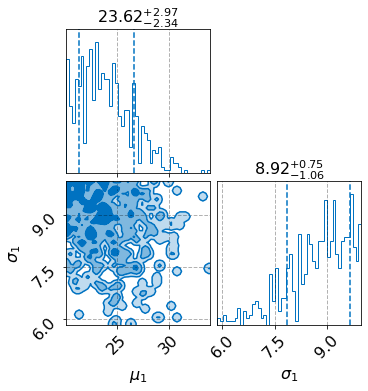

In [12]:
#plot results

result.plot_corner()

## Challenge
Can you create a model similar to the ones used in the LVK? Hint: feel free to use models in GWPopulation :)